In [30]:
sigma_alpha = 10
eta_alpha = .3
sigma_z = 50
eta_z = 10
kappa = .5 #big enough
phi = 0.0001
b = .24
l = .5
alpha_I = 0.0001
psi = alpha_I + b/2
T = .7
N = 100
N_steps = 1_000
Batch_size = 100
kappa_z = 1
Number_size= 200
dt = T/N
rho = 1

!pip install torch

In [31]:
import torch
import torch.nn as nn
import numpy as np

class ZNet(nn.Module):
    def __init__(self, input_dim, output_dim=1, hidden_dim=64):
        super(ZNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, q_t,alpha_t,z_t):
        xy = torch.cat([q_t,alpha_t,z_t], dim=1)
        return self.net(xy)


In [32]:
def simulate_trajectory(Q0_I,Q0_U, Y0,Z_nets, 
                        b_QI,b_QU,b_Y, T, N, dW_S,dW_A,dW_Z):
    dt = T / N
    Q_I,Q_U, Y_I,Z_vals_S,Z_vals_A,Z_vals_Z,alpha,Z= [Q0_I],[Q0_U], [Y0],[],[],[], [torch.zeros(1, 1).expand(Q0_I.shape[0], -1)],[torch.zeros(1, 1).expand(Q0_I.shape[0], -1)]

    for i in range(N):
        t = i * dt
        q_I,q_U, y_I,Alpha_t,Z_t = Q_I[-1],Q_U[-1], Y_I[-1],alpha[-1],Z[-1]
        
        z_S = Z_nets[0][i](q_I,Alpha_t,Z_t)
        z_A = Z_nets[1][i](q_I,Alpha_t,Z_t)
        z_Z = Z_nets[2][i](q_I,Alpha_t,Z_t)
        
        Z_vals_S.append(z_S)
        Z_vals_A.append(z_A)
        Z_vals_Z.append(z_Z)
        
        dWt_S = dW_S[:, i, :]
        dWt_A = dW_A[:, i, :]
        dWt_Z = dW_Z[:, i, :]
        
        q_I_next = q_I + b_QI(l,q_U,y_I) * dt 
        q_U_next = q_U + b_QU(Z_t) * dt
        
        y_I_next = y_I + b_Y(q_I,Alpha_t) * dt + z_S * dWt_S + z_A * dWt_A + z_Z*dWt_Z
        alpha_next = Alpha_t - eta_alpha * Alpha_t * dt + dWt_A*sigma_alpha
        z_next = Z_t - eta_z*Z_t*dt + dWt_Z*sigma_z
        
        alpha.append(alpha_next)
        Z.append(z_next)
        Q_I.append(q_I_next)
        Q_U.append(q_U_next)
        Y_I.append(y_I_next)    
        
    return Q_I,Q_U,Y_I,Z_vals_S,Z_vals_A,Z_vals_Z,alpha,Z


In [33]:
def compute_loss(Y_I_T,Q_I_T):
    target_I = -2*psi*Q_I_T
    return torch.mean((Y_I_T - target_I) ** 2)


In [34]:
def train(Z_nets, Y0_I, Q0_I, Q0_U, b_QI, b_QU, b_Y,T, N, num_steps=N_steps, batch_size=Batch_size):
    optimizer = torch.optim.Adam(
        [{'params': net.parameters()} for net_list in Z_nets for net in net_list] + [{'params': [Y0_I]}], 
        lr=1e-3
    )

    for step in range(num_steps):
        dW_S = torch.randn(batch_size, N, Y0_I.shape[1]) * (T / N) ** 0.5
        dW_A = torch.randn(batch_size, N, Y0_I.shape[1]) * (T / N) ** 0.5
        dW_Z = dW_S*rho + np.sqrt(1-rho**2)*torch.randn(batch_size, N, Y0_I.shape[1]) * (T / N) ** 0.5


        Q_I_list,Q_U_list, Y_I_list,_,_,_,_,_ = simulate_trajectory(
            Q0_I.expand(batch_size, -1), Q0_U.expand(batch_size,-1), Y0_I.expand(batch_size, -1),
            Z_nets, b_QI,b_QU,b_Y, T, N, dW_S,dW_A,dW_Z
        )
        loss = compute_loss(Y_I_list[-1], Q_I_list[-1],)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step % 100 == 0:
            print(f"Step {step}, Loss: {loss.item():.5f}")

    return dW_S,dW_A,dW_Z
            

In [35]:
def b_QI(l,q_U,y_I):
    c = -l-b*q_U + y_I
    tilde_c = -l+b*q_U - y_I

    left = torch.where(
        c > 0,
       c/(2*kappa),
        torch.zeros_like(c)
    )
    right = torch.where(
        tilde_c > 0,
        tilde_c/(2*kappa),
        torch.zeros_like(tilde_c)
    )
    return left - right

def b_QU(Z_t):
    return kappa_z*Z_t

def b_Y(q_I, alpha):
    return 2 * phi * q_I - alpha


In [36]:
dim_q_I = 1
dim_q_U = 1
dim_y = 1
input_dim = dim_q_I + dim_q_U + dim_y

Z_nets = [
    [ZNet(input_dim=input_dim) for _ in range(N)]  
    for _ in range(3)
]

Q0_I = torch.zeros(1, dim_q_I)
Q0_U = torch.zeros(1, dim_q_U)
Y0_I = nn.Parameter(torch.zeros(1, dim_y))

dW_S, dW_A,dW_Z = train(Z_nets, Y0_I, Q0_I, Q0_U, b_QI, b_QU, b_Y,T, N)

Step 0, Loss: 9.60718
Step 100, Loss: 3.17925
Step 200, Loss: 1.84195
Step 300, Loss: 2.00537
Step 400, Loss: 1.23855
Step 500, Loss: 0.98669
Step 600, Loss: 0.59694
Step 700, Loss: 0.47535
Step 800, Loss: 0.31644
Step 900, Loss: 0.22116


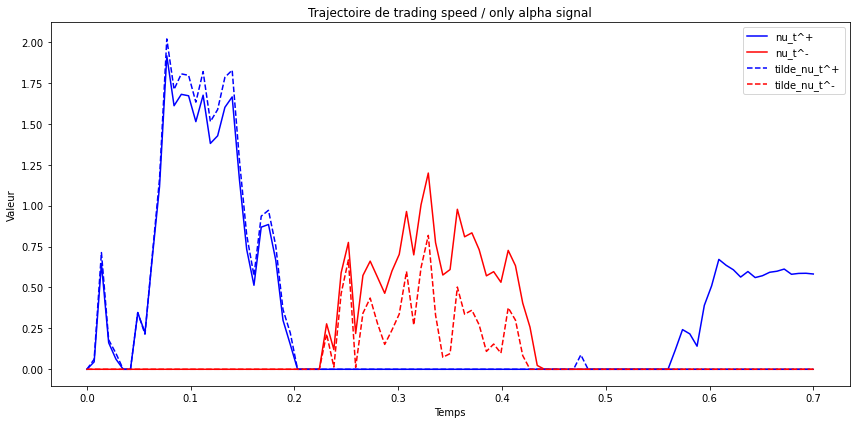

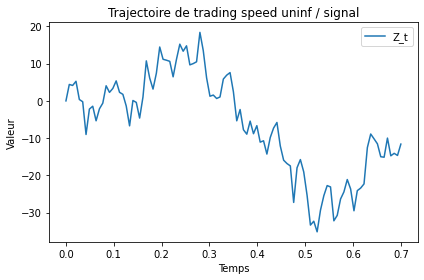

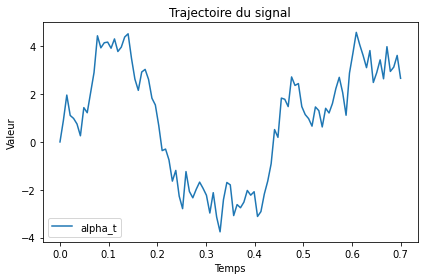

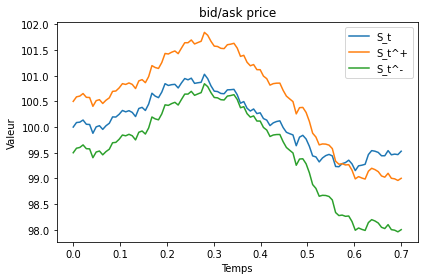

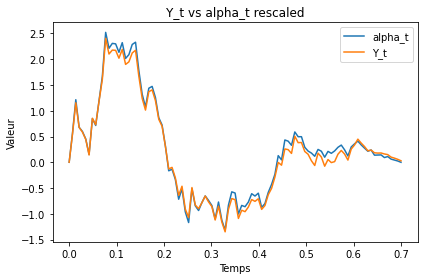

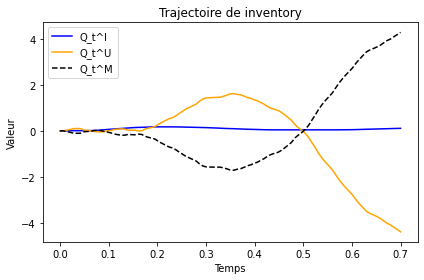

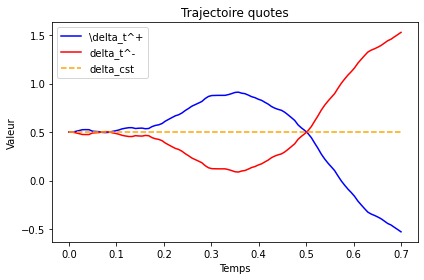

In [45]:
import matplotlib.pyplot as plt
# Fonction pour afficher les courbes après l'entraînement
def plot_trajectory(Q_I, Q_U, Y_I, Z, alpha, dW_S, T, N, idx=0,number_size=Number_size):
    # Création d'un vecteur de temps
    time_grid = [i * T / N for i in range(N+1)]

    # Récupération des valeurs pour un élément spécifique du batch
    Q_I_vals = [Q_I[t][idx].item() for t in range(N+1)]
    Q_U_vals = [Q_U[t][idx].item() for t in range(N+1)]
    Y_I_vals = [Y_I[t][idx].item() for t in range(N+1)]
    alpha_vals = [alpha[t][idx].item() for t in range(N+1)]
    Z_vals = [Z[t][idx].item() for t in range(N+1)]
    
    
    alpha_values=[]
    for t in range(N+1):
        alpha_values.append(alpha_vals[t]*(1-np.exp(-eta_alpha*(T-time_grid[t])))/eta_alpha)
        
    true_nu_plus = []
    true_nu_minus=[]
    tilde_delta_plus = []
    tilde_delta_minus = []
    delta_plus = []
    delta_minus = []
    c=[]
    tilde_c =[]
    for t in range(N+1):
        delta_plus.append(l+b*Q_U_vals[t]+b*Q_I_vals[t])
        delta_minus.append(l-b*Q_U_vals[t]-b*Q_I_vals[t])

        tilde_delta_plus.append(l+b*Q_U_vals[t])
        tilde_delta_minus.append(l-b*Q_U_vals[t])

        c.append(-tilde_delta_plus[t]+Y_I_vals[t])
        tilde_c.append(-tilde_delta_minus[t]-Y_I_vals[t])
        

    nu_plus = []
    nu_minus = []
   
    for t in range(N+1):
        if -l+alpha_vals[t]*(1-np.exp(-eta_alpha*(T-time_grid[t])))/eta_alpha > 0:
            true_nu_plus.append((-l+alpha_vals[t]*(1-np.exp(-eta_alpha*(T-time_grid[t])))/eta_alpha)/(2*kappa))
        else:
            true_nu_plus.append(0)
            
    for t in range(N+1):
        if -l-alpha_vals[t]*(1-np.exp(-eta_alpha*(T-time_grid[t])))/eta_alpha > 0:
            true_nu_minus.append((-l-alpha_vals[t]*(1-np.exp(-eta_alpha*(T-time_grid[t])))/eta_alpha)/(2*kappa))
        else:
            true_nu_minus.append(0)


    for t in range(N+1):
        if c[t] <= 0:
            nu_plus.append(0)
        else:
            nu_plus.append(c[t]/(2*kappa))
    
    for t in range(N+1):
        if tilde_c[t] <= 0:
            nu_minus.append(0)
        else:
            nu_minus.append(tilde_c[t]/(2*kappa))
    
    S_t = [100]
    for t in range(N):
        S_t.append(S_t[t] + alpha_vals[t]*(T / N) + dW_S[idx,t,:])
            
    
    # Tracer les courbes pour Q_I, Q_M, Y_I, Y_M
    plt.figure(figsize=(12, 6))

    # Trajectoire pour Q_I et Q_M
    plt.plot(time_grid, nu_plus, label="nu_t^+", color='blue')
    plt.plot(time_grid, nu_minus, label="nu_t^-", color='red')
    plt.plot(time_grid, true_nu_plus, '--',label="tilde_nu_t^+", color='blue')
    plt.plot(time_grid, true_nu_minus,'--',label="tilde_nu_t^-", color='red')
    plt.title("Trajectoire de trading speed / only alpha signal")
    plt.xlabel("Temps")
    plt.ylabel("Valeur")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    plt.plot(time_grid,Z_vals,label='Z_t')
    #plt.plot(time_grid,alpha_vals,label='alpha_t')
    plt.title("Trajectoire de trading speed uninf / signal")
    plt.xlabel("Temps")
    plt.ylabel("Valeur")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
        
    plt.plot(time_grid,alpha_vals,label='alpha_t')
    plt.title("Trajectoire du signal")
    plt.xlabel("Temps")
    plt.ylabel("Valeur")
    plt.legend()
    plt.tight_layout()
    plt.show()

    
    plt.plot(time_grid,S_t,label='S_t')
    plt.plot(time_grid,np.array(S_t) + np.array(delta_plus),label='S_t^+')
    plt.plot(time_grid,np.array(S_t) - np.array(delta_minus),label='S_t^-')
    plt.title("bid/ask price")
    plt.xlabel("Temps")
    plt.ylabel("Valeur")
    plt.legend()
    plt.tight_layout()
    plt.show()

    
    
    plt.plot(time_grid,alpha_values,label='alpha_t')
    plt.plot(time_grid,Y_I_vals,label="Y_t")
    plt.title("Y_t vs alpha_t rescaled")
    plt.xlabel("Temps")
    plt.ylabel("Valeur")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    plt.plot(time_grid, Q_I_vals, label="Q_t^I", color='blue')
    plt.plot(time_grid, Q_U_vals, label="Q_t^U", color='orange')
    plt.plot(time_grid, (-1)*np.array(Q_I_vals) + (-1)*np.array(Q_U_vals),'--', label="Q_t^M", color='black')
    plt.title("Trajectoire de inventory")
    plt.xlabel("Temps")
    plt.ylabel("Valeur")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    plt.plot(time_grid, delta_plus, label="\delta_t^+", color='blue')
    plt.plot(time_grid, delta_minus, label="delta_t^-", color='red')
    plt.plot(time_grid,np.array([l for k in range(len(delta_plus))]),'--', label="delta_cst", color="orange")
    plt.title("Trajectoire quotes")
    plt.xlabel("Temps")
    plt.ylabel("Valeur")
    plt.legend()
    plt.tight_layout()
    plt.show()
    


# Fonction principale pour récupérer les valeurs et afficher les courbes
def plot_after_training(number_size=Number_size):
    dW_S =  torch.randn(number_size, N, Y0_I.shape[1]) * (T / N) ** 0.5
    dW_A =  torch.randn(number_size, N, Y0_I.shape[1]) * (T / N) ** 0.5
    dW_Z = rho*dW_S + np.sqrt(1-rho**2)* torch.randn(number_size, N, Y0_I.shape[1]) * (T / N) ** 0.5

    Q_I, Q_U, Y_I, _, _,_, alpha,Z = simulate_trajectory(
        Q0_I.expand(number_size, -1), Q0_U.expand(number_size, -1), Y0_I.expand(number_size, -1), Z_nets, b_QI, b_QU, b_Y, T, N,
   dW_S,dW_A,dW_Z)
    
    # Affichage des courbes pour le premier élément du batch

    plot_trajectory(Q_I, Q_U, Y_I, Z,alpha, dW_S,T, N,idx=150,number_size=Number_size)

# Appeler la fonction pour afficher les courbes après l'entraînement
plot_after_training()


In [42]:
def PnL(nb_it = 100_000):
    S0 =  torch.tensor([[100]])
    dW_S =  torch.randn(nb_it, N, Y0_I.shape[1]) * (T / N) ** 0.5
    dW_A =  torch.randn(nb_it, N, Y0_I.shape[1]) * (T / N) ** 0.5
    dW_Z =  rho*dW_S + np.sqrt(1-rho**2)*torch.randn(nb_it, N, Y0_I.shape[1]) * (T / N) ** 0.5
    Q_I, Q_U, Y_I, _, _,_, alpha,Z = simulate_trajectory(
        Q0_I.expand(nb_it, -1), Q0_U.expand(nb_it, -1), Y0_I.expand(nb_it, -1), Z_nets, b_QI, b_QU, b_Y, T, N,
   dW_S,dW_A,dW_Z)
    X =  Q0_I.expand(nb_it, -1)
    S =  S0.expand(nb_it, -1)
    Q_tot = Q0_U.expand(nb_it, -1)
    X_U =  Q0_I.expand(nb_it, -1)
    Q_tot_U = Q0_U.expand(nb_it, -1)
    for t in range(N):
        delta_plus = l+b*Q_U[t]+b*Q_I[t]
        delta_moins = l-b*Q_U[t]-b*Q_I[t]
        c = -l-b*Q_U[t] + Y_I[t]
        tilde_c = -l+b*Q_U[t] - Y_I[t]
        nu_plus = torch.where(c > 0, c/(2*kappa),torch.zeros_like(c))
        nu_moins = torch.where(tilde_c > 0, tilde_c/(2*kappa),torch.zeros_like(tilde_c))
        X = X + (S-delta_moins - kappa*nu_plus)*nu_plus*dt - (S+delta_plus+kappa*nu_plus)*nu_plus*dt
        X_U = X_U + (S-delta_moins - kappa*torch.where(Z[t] < 0, -Z[t],torch.zeros_like(Z[t])))*torch.where(Z[t] < 0, -Z[t],torch.zeros_like(Z[t]))*dt - (S+delta_plus+kappa*torch.where(Z[t] > 0, Z[t],torch.zeros_like(Z[t])))*torch.where(Z[t] > 0, Z[t],torch.zeros_like(Z[t]))*dt
        S = S +alpha[t]*dt + dW_S[:,t,:]
        Q_tot=Q_tot+Q_I[t]**2*dt
        Q_tot_U=Q_tot_U+Q_U[t]**2*dt

    data_I = (X + S*Q_I[-1]- alpha_I*Q_I[-1]**2-phi*Q_tot).detach().numpy()
    data_U = (X + S*Q_U[-1]- alpha_I*Q_U[-1]**2-phi*Q_tot_U).detach().numpy()

    return data_I,data_U


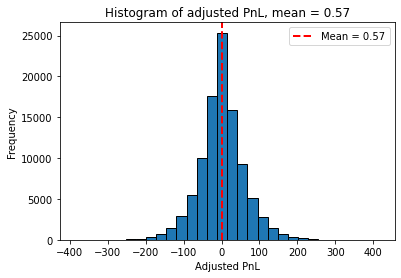

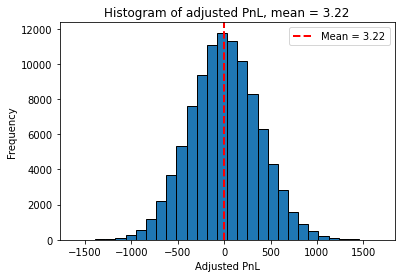

In [43]:
#seed = 3645765
#torch.manual_seed(seed)
data_I,data_U = PnL()
data_I = np.array(data_I)
data_U = np.array(data_U)
mean_value_I = data_I.mean()
mean_value_U = data_U.mean()

plt.hist(data_I, bins=30, edgecolor='black')
plt.axvline(mean_value_I, color='red', linestyle='--', linewidth=2, label=f'Mean = {mean_value_I:.2f}')
plt.title(f"Histogram of adjusted PnL, mean = {mean_value_I:.2f}")
plt.xlabel("Adjusted PnL")
plt.ylabel("Frequency")
plt.legend()
plt.show()


plt.hist(data_U, bins=30, edgecolor='black')
plt.axvline(mean_value_U, color='red', linestyle='--', linewidth=2, label=f'Mean = {mean_value_U:.2f}')
plt.title(f"Histogram of adjusted PnL, mean = {mean_value_U:.2f}")
plt.xlabel("Adjusted PnL")
plt.ylabel("Frequency")
plt.legend()
plt.show()
